In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio, display
import numpy as np

import os
import time
import cmath


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Constants and settings
WINDOW_SIZE = 25  # Has to be odd
TARGET_COL = WINDOW_SIZE//2

DTYPE = 'float32'

# cqt related
FFT_BINS = 513 # function of items below
HOP_LENGTH = 512

# stft values
N_FFT = 1024 # 512 recommended for speech, music typically 2048

# cqt values
#BINS_PER_OCTAVE = 12 * 10
#FMIN = librosa.note_to_hz('C1')
#OCTAVES = 8

In [3]:
# Idea here is that we operate on magnitude, and will just use phase from the original noisy sample

def combine_target(t):
    return (t[0:t.shape[0]//2] + 1j * t[t.shape[0]//2:]).reshape(1,(t.shape[0]//2))

def rebuild_fft(output, original_fft):
    vphase = np.vectorize(cmath.phase)
    o_phase = vphase(original_fft)
    mag = output.T
    vrect = np.vectorize(cmath.rect)
    return vrect(mag, o_phase)
    
# build up as (bins, samples) then transpose to model view of (samples, bins)
def targets_to_fft(targets):
    fft = np.empty((targets.shape[0],targets.shape[1]//2), dtype='complex64')
    for i in range(0, targets.shape[0]):
        fft[i] = combine_target(targets[i])
    return fft.T   # transpose

def get_ft(wav):
    #c = librosa.cqt(wav, hop_length=HOP_LENGTH, fmin=FMIN, n_bins=OCTAVES*BINS_PER_OCTAVE, bins_per_octave=BINS_PER_OCTAVE)
    c = librosa.stft(wav, hop_length=HOP_LENGTH, n_fft=N_FFT)
    return c

def inv_ft(ft):
    #return librosa.icqt(ft, hop_length=HOP_LENGTH, bins_per_octave=BINS_PER_OCTAVE)
    return librosa.istft(ft, hop_length=HOP_LENGTH)
    

In [4]:
# some test data to hack around with
test_file = "Assets\\DataShareArchive\\Test\\Clean\\p232_010.wav"
wav, rate = librosa.core.load(test_file)
fft = get_ft(wav)
#print(fft.shape)

In [5]:
# Creating data from clip wave file
# Need to get a subset of the memory mapped file to work on

# Frame output is (samples, bins, window size, layers), where image is depth 2 for real & imaginary
def clip_frames(file, frames_view):
    wav, rate = librosa.core.load(file)
    frame_lead = (WINDOW_SIZE-1)//2  # The amount before and after the target column
    fft = get_ft(wav) # organized as bins, frames
    bins = fft.shape[0]
    max_frames = min(fft.shape[1], frames_view.shape[0])
    pad = np.zeros((bins,frame_lead))
    fft = np.concatenate([pad, fft, pad], axis=-1)
    for i in range(0, max_frames):
        frames_view[i,:,:,0] = abs(fft[:,i:i+WINDOW_SIZE])

# output is array (samples, double bin length made up of real then imag)
# Targets output is array (samples, double bin length made up of real then imag)
def clip_targets(file, targets_view):
    wav, rate = librosa.core.load(file)
    frame_lead = (WINDOW_SIZE-1)//2  # The amount before and after the target column
    fft = get_ft(wav)
    bins = fft.shape[0]
    for i in range(0, min(fft.shape[1], targets_view.shape[0])) :
        targets_view[i,:] = abs(fft[:,i:i+1]).flatten()
    return fft.shape[1]

In [6]:
def frames_file(data_path, max_samples):
    frames_file = data_path + "\\frames-" + str(max_samples)
    filename = os.fsdecode(frames_file)
    return filename

def targets_file(data_path, max_samples):
    targets_file = data_path + "\\targets-" + str(max_samples)
    filename = os.fsdecode(targets_file)
    return filename

# Iterate over clean & noisy folders to create frames and targets
def create_data(wav_root, data_path, max_samples = 10000):
    clean_dir = wav_root + "\\Clean\\"
    noisy_dir = wav_root + "\\Noisy\\"
    sample_index = 0
    frames = np.memmap(frames_file(data_path, max_samples), mode='w+', dtype=DTYPE, shape=(max_samples,FFT_BINS,WINDOW_SIZE,1))
    targets = np.memmap(targets_file(data_path, max_samples), mode='w+', dtype=DTYPE, shape=(max_samples,FFT_BINS))
    file_list = os.listdir(clean_dir)
    file_index = 0
    while (sample_index < max_samples) and (file_index < len(file_list)) :
        file = file_list[file_index]
        filename = os.fsdecode(file)
        clip_frames(noisy_dir + file, frames[sample_index:,:,:,:])
        sample_increment = clip_targets(clean_dir + file, targets[sample_index:,:])
        sample_index += sample_increment
        file_index += 1
    print("Reached sample # " + str(min(sample_index, max_samples)))
    return frames, targets


In [7]:
# Training data comes in at 89651 samples total
f, t = create_data("Assets\\DataShareArchive\\Test", "f:\\Audiodata", max_samples=89000)



Reached sample # 89000


In [9]:
print(t.shape, f.shape)
i = 2
print(f[i,0, 12:13, 0])
print(t[i,0])

(89000, 513) (89000, 513, 25, 1)
[0.37703788]
0.6450009


In [51]:
for i in range(0,120):
    for j in range(0,2):
        if f[i, j, 12, 0] != t[i,j]:
            print ("oh no i ", i, ", j ", j, "   ", )
            print(f[i, j, 12, 0], " != ", t[i,j], "   diff ", f[i, j, 12, 0] - t[i,j])
print("done")
print(i)

oh no i  1 , j  1    
1.1500673797860452  !=  1.1500673294067383    diff  5.0379306948400426e-08
oh no i  2 , j  1    
1.0655576948337218  !=  1.0655577182769775    diff  -2.3443255781074868e-08
oh no i  3 , j  1    
1.7149982551964824  !=  1.7149982452392578    diff  9.957224600398717e-09
oh no i  4 , j  1    
1.3355032314820166  !=  1.3355032205581665    diff  1.0923850046751227e-08
oh no i  5 , j  1    
0.23373464975664965  !=  0.23373465240001678    diff  -2.643367136290209e-09
oh no i  6 , j  1    
1.6848497616425884  !=  1.684849739074707    diff  2.256788134147314e-08
oh no i  7 , j  1    
1.1913290790018292  !=  1.1913291215896606    diff  -4.2587831483587024e-08
oh no i  8 , j  1    
1.1391269890060127  !=  1.1391270160675049    diff  -2.7061492158253486e-08
oh no i  9 , j  1    
1.2651699837859656  !=  1.2651699781417847    diff  5.644180900432616e-09
oh no i  10 , j  1    
0.9175754738497011  !=  0.917575478553772    diff  -4.704070910577229e-09
oh no i  11 , j  1    
1.5895

In [9]:
frames = np.load("frames-0-500.npy", mmap_mode='r')
targets = np.load("targets-0-500.npy", mmap_mode='r')

Test & reference stuff 

(120, 513, 25, 1)
(120, 513)
0.002826246665790677
[0.00282625]
(513, 120)


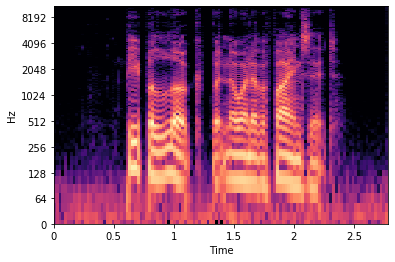

In [6]:
ft = clip_frames(test_file)
tt = clip_targets(test_file)

print(ft.shape)
print(tt.shape)

#Frame / target check  -  don't use first row because it might be zeroed out
r = 10
print(tt[0,r])
print(ft[0,r,TARGET_COL:TARGET_COL+1,0])

# Round trip test
new_fft = rebuild_fft(tt, fft)
print(new_fft.shape)
new_wav = inv_ft(new_fft)

librosa.display.specshow(librosa.amplitude_to_db(np.abs(new_fft), ref=np.max), y_axis='log', x_axis='time')

Audio(new_wav,rate=22050)

In [3]:
t = np.zeros((3,4,5))

def setter(view):
    print(view.shape)
    view[0,0] = 1

setter(t[1:2,:,3:4])

(1, 4, 1)


In [4]:
print(t)

[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
